In [1]:
import numpy as np
from collections import defaultdict
from src.finance_problems.optimal_order_exec import LPIMarket, DumpStockRLProblem, DumpStockMDP, TimeDependantDumpStockRLProblem
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from src.rl_algos.control import QLearningTabular

# MDP Formulation

Here we create an idealized version of the optimal order execution problem, we model market impact with a linear model, and we model the random movement as $P_{t+1} = P_t - \beta N_t + \epsilon_t$ where
$\epsilon_t = \begin{cases}0,\ p=\frac{1}{2}\\ 1,\ p=\frac{1}{4}\\ -1,\ p=\frac{1}{4}\end{cases}$
We see that we approach the analytic solution, with some interesting behavior when the price is either at the limit (50) or near zero, however for the vast majority of cases we see that the optimal behavior is to sell $\frac{R_t}{T-t+1}$ at each t

In [48]:
dsmdp = DumpStockMDP(5, 10, 1, 0.1, 1, min_price=0,max_price=50)
opt_policy = dsmdp.solve()
agg_policies = defaultdict(list)
for state in opt_policy:
    agg_policies[(state[0], state[2])] += list(opt_policy[state])[0]

In [49]:
policyx, policyy, policyz = [], [], []
optpolicyz = []
for state in agg_policies:
    policyx.append(state[0])
    policyy.append(state[1])
    policyz.append(np.mean(agg_policies[state]))
    if state[0] > 0:
        optpolicyz.append(state[1]/state[0])
    else:
        optpolicyz.append(0)

We now plot the MDP calculated greedy policy vs the optimal policy, as we can see, that match quite closely

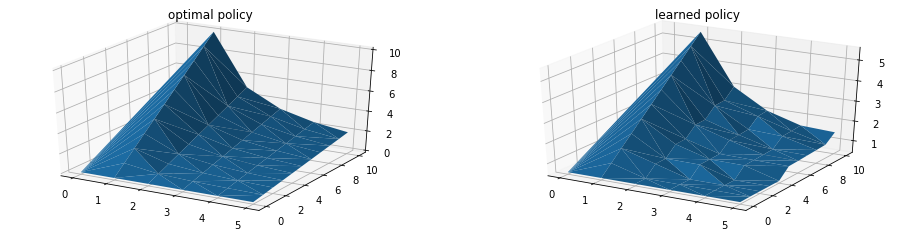

In [50]:
fig = plt.figure(figsize=(16,4))

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.set_title('optimal policy')
ax.plot_trisurf(policyx,policyy, optpolicyz)


ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.set_title('learned policy')
ax.plot_trisurf(policyx,policyy, policyz)

plt.show()

# RL Formulation

We now solve the problem with RL (the model uses tabular qlearning in the solve method). We use a market simulator to experience episodes. The market simulator uses the linear impact model parameterized by $\alpha, \beta$ however the next price follows a normal distribution centered around the previous impacted price. 
$p_{t+1} = p_t - \beta N_t + \epsilon$ where $\epsilon \sim \mathcal{N}(0,1)$, the states are $(t, r_t, p_t)$. In this formulation we look at 10 timesteps and 20 shares to sell. Although the state space is large $\sim 4240$ states, we start to converge after only 10 minutes of training ($5e^5$ episodes).

In [51]:
market = LPIMarket(25, alpha=0.01, beta=1)
dsp = TimeDependantDumpStockRLProblem(10, 20, market)
policy, q_func = dsp.solve(max_episodes=1e6)

In [52]:
agg_policies = defaultdict(list)

for state in dsp.states:
    if state[0] > 0:
        agg_policies[(state[0], state[1])] += [policy.get_action(state)]

    else:
        agg_policies[(state[0], state[1])] = [0]

policyx, policyy, policyz = [], [], []
policyvar = []
optpolicyz = []
for state in agg_policies:
    policyx.append(state[0])
    policyy.append(state[1])
    policyz.append(np.mean(agg_policies[state]))
    policyvar.append(np.var(agg_policies[state]))
    if state[0] > 0:
        optpolicyz.append(state[1]/state[0])
    else:
        optpolicyz.append(0)


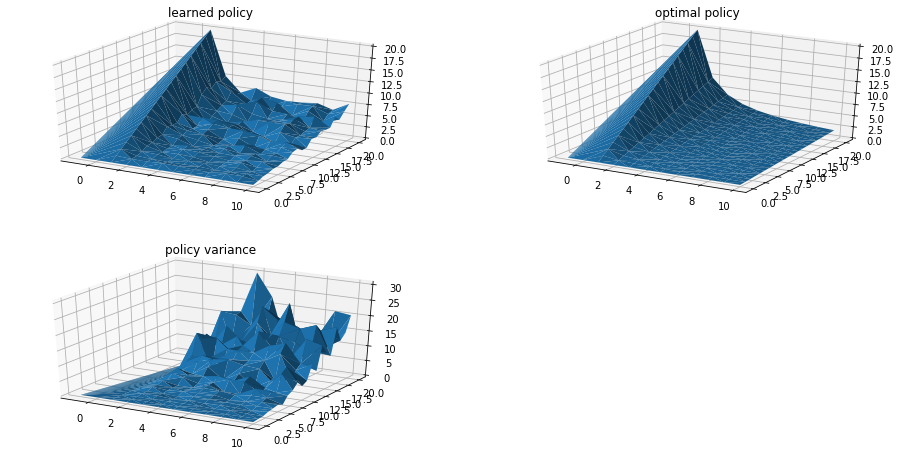

In [53]:
fig = plt.figure(figsize=(16,8))

ax = fig.add_subplot(2, 2, 2, projection='3d')
ax.set_title('optimal policy')
ax.plot_trisurf(policyx,policyy, optpolicyz)


ax = fig.add_subplot(2, 2, 1, projection='3d')
ax.set_title('learned policy')
ax.plot_trisurf(policyx,policyy, policyz)


ax = fig.add_subplot(2, 2, 3, projection='3d')
ax.set_title('policy variance')
ax.plot_trisurf(policyx,policyy, policyvar)

plt.show()

As we can see, the policy is converging to the optimal policy. The final plot is the variance of the optimal policy at that price and shares remaining. We can see that the variance increases as it approaches the boundary states (states which are visited less frequently). To look at a large state space, we use our knowledge that the strategy should be independant of price, and are therefore able to consider larger state spaces. In this formulation, the state is only $(t, r_t)$

In [41]:
market = LPIMarket(150, alpha=0.01, beta=1)
dsp = DumpStockRLProblem(10, 50, market)
policy, q_func = dsp.solve(max_episodes=1e6)

In [42]:
policyx, policyy, policyz = [], [], []
optpolicyz = []
for state in dsp.states:
    policyx.append(state[0])
    policyy.append(state[1])
    policyz.append(policy.get_action(state))
    if state[0] > 0:
        optpolicyz.append(state[1]/state[0])
    else:
        optpolicyz.append(0)

We now plot the greedy policy from the learned value function vs the optimal policy, as we can see, it is converging to the optimal policy.

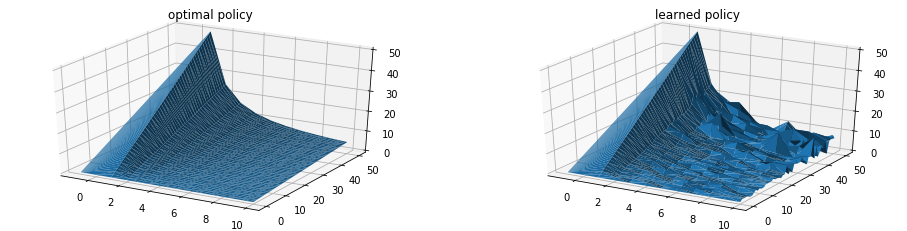

In [43]:
fig = plt.figure(figsize=(16,4))

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.set_title('optimal policy')
ax.plot_trisurf(policyx,policyy, optpolicyz)


ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.set_title('learned policy')
ax.plot_trisurf(policyx,policyy, policyz)

plt.show()

In fact, it converges much more quickly and smoothly than version which takes into account price, we would expect this kind of convergence on the price dependant mondel given more training resources.

Finally we take a look at how convergence improves as we train for more episodes.

learning for 5e2 episodes



learning for 5e3 episodes



learning for 5e4 episodes



learning for 5e5 episodes


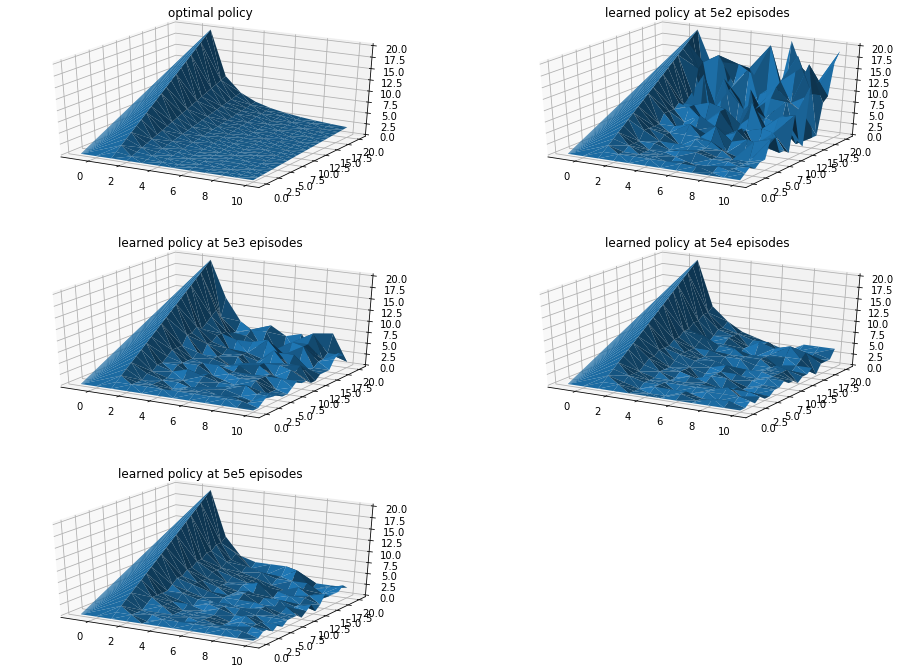

In [47]:
fig = plt.figure(figsize=(16,12))


for i in range(2,6):
    print(f'learning for 5e{i} episodes')
    market = LPIMarket(25, alpha=0.01, beta=1)
    dsp = DumpStockRLProblem(10, 20, market)
    policy, q_func = dsp.solve(max_episodes=5*10**i)
    policyx, policyy, policyz = [], [], []
    optpolicyz = []
    for state in dsp.states:
        policyx.append(state[0])
        policyy.append(state[1])
        policyz.append(policy.get_action(state))
        if state[0] > 0:
            optpolicyz.append(state[1]/state[0])
        else:
            optpolicyz.append(0)
            
    if i == 2:
        ax = fig.add_subplot(3, 2, 1, projection='3d')
        ax.set_title('optimal policy')
        ax.plot_trisurf(policyx,policyy, optpolicyz)
    
    ax = fig.add_subplot(3, 2, i, projection='3d')
    ax.set_title(f'learned policy at 5e{i} episodes')
    ax.plot_trisurf(policyx,policyy, policyz)
    
plt.show()